In [1]:
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
import time
import copy
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import seaborn as sns
import torchvision.transforms.v2 as v2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
%matplotlib inline

In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dir="/kaggle/input/dog-vs-cat-fastai/dogscats/train/"
valid_dir="/kaggle/input/dog-vs-cat-fastai/dogscats/valid/"
test_dir="/kaggle/input/dog-vs-cat-fastai/dogscats/test1/"

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


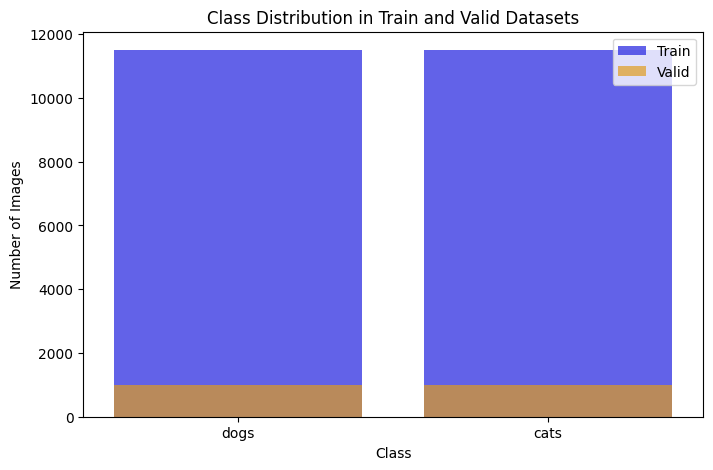

In [4]:
# Count images in each class for training and validation
train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}
valid_counts = {cls: len(os.listdir(os.path.join(valid_dir, cls))) for cls in os.listdir(valid_dir)}

# Convert to lists for plotting
categories = list(train_counts.keys())
train_values = list(train_counts.values())
valid_values = list(valid_counts.values())

# Create a bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=categories, y=train_values, label="Train", color="blue", alpha=0.7)
sns.barplot(x=categories, y=valid_values, label="Valid", color="orange", alpha=0.7)

# Add labels and title
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Train and Valid Datasets")
plt.legend()
plt.show()

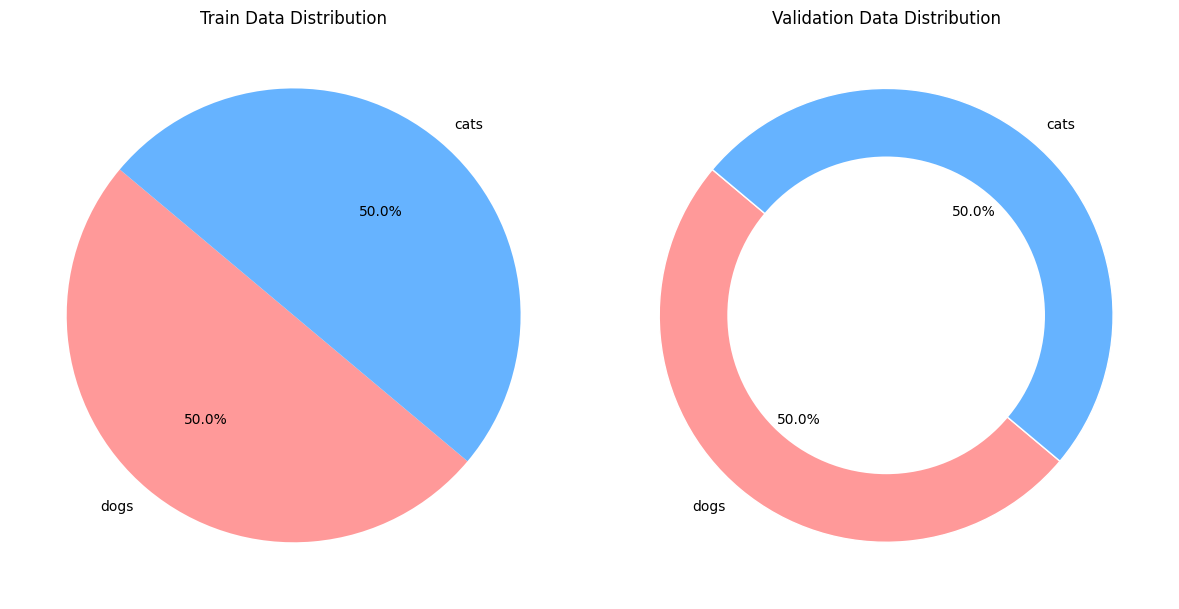

In [5]:
# Define labels and sizes
categories = list(train_counts.keys())
train_sizes = list(train_counts.values())
valid_sizes = list(valid_counts.values())

# Define colors
colors = ['#ff9999','#66b3ff']

# Create Pie Chart for Training Data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(train_sizes, labels=categories, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title("Train Data Distribution")

# Create Donut Chart for Validation Data
plt.subplot(1, 2, 2)
plt.pie(valid_sizes, labels=categories, autopct='%1.1f%%', colors=colors, startangle=140, wedgeprops={'edgecolor': 'white'})
plt.gca().add_artist(plt.Circle((0, 0), 0.7, fc='white'))  # Creates the hole for the donut effect
plt.title("Validation Data Distribution")

plt.tight_layout()
plt.show()

# Transforming and augmenting images

In [6]:


transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to 128x128
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])


# Count Images in train & valid directory

In [7]:
import os
from tqdm import tqdm

def get_image_files(base_dir):
    """Retrieve image file paths from 'dogs/' and 'cats/' subdirectories."""
    file_paths = []
    for subdir in ['dogs', 'cats']:
        subdir_path = os.path.join(base_dir, subdir)
        if not os.path.exists(subdir_path):
            print(f"⚠️ Warning: Subdirectory '{subdir}' not found in {base_dir}")
            continue  # Skip missing classes

        files = [f for f in os.listdir(subdir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        for file_name in tqdm(files, desc=f"Loading {subdir} images", leave=False):
            file_paths.append(os.path.join(subdir, file_name))  # Store relative paths

    return file_paths

# Get files for train and validation
train_files = get_image_files(train_dir)
valid_files = get_image_files(valid_dir)




In [8]:
import os

# Extract class names from the directory structure of train files
train_classes = set()

# Loop through the train files and get class names from directory names
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    if os.path.isdir(subdir_path):  # Check if it's a directory (class)
        train_classes.add(subdir)  # Add class name (subdir) to the set

# Print out the unique classes in the training dataset
print(f"Classes in training dataset: {train_classes}")
print(f"Number of classes: {len(train_classes)}")


Classes in training dataset: {'cats', 'dogs'}
Number of classes: 2


In [9]:
# Extract class names from the directory structure of valid files
valid_classes = set()

# Loop through the validation files and get class names from directory names
for subdir in os.listdir(valid_dir):
    subdir_path = os.path.join(valid_dir, subdir)
    if os.path.isdir(subdir_path):  # Check if it's a directory (class)
        valid_classes.add(subdir)  # Add class name (subdir) to the set

# Print out the unique classes in the validation dataset
print(f"Classes in validation dataset: {valid_classes}")
print(f"Number of classes: {len(valid_classes)}")


Classes in validation dataset: {'cats', 'dogs'}
Number of classes: 2


In [10]:

print(f'Number of Train  images is : {len(train_files)}')
print(f'Number of Valid images is : {len(valid_files)}')

Number of Train  images is : 23000
Number of Valid images is : 2000


# Create Dataset

In [11]:
import os
from PIL import Image
from torch.utils.data import Dataset

class DogCatDataset(Dataset):
    def __init__(self, file_paths, root_dir, transform=None):
        self.file_paths = file_paths  # This should contain relative paths like "dogs/dog.7971.jpg"
        self.root_dir = root_dir  # Base directory
        self.transform = transform
        self.class_to_idx = {'cats': 0, 'dogs': 1}

        # Correcting the full path issue
        self.data = [(os.path.join(root_dir, img_path), self.class_to_idx[img_path.split('/')[0]]) for img_path in file_paths]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        
        # Ensure the file exists before opening
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")

        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


# Create our train and test dataset objects

In [12]:
train_dataset = DogCatDataset(train_files, train_dir, transform=transform)
valid_dataset = DogCatDataset(valid_files, valid_dir, transform=transform)


In [13]:
# # Print class mapping
# print(f"Class mapping: {valid_dataset.class_to_idx}")

# # Get unique classes from the dataset
# unique_classes = set(label for _, label in train_dataset)
# print(f"Unique classes in train_dataset: {unique_classes}")
# print(f"Number of classes: {len(unique_classes)}")



# Create DataLoader

In [14]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

img_custom, label_custom = next(iter(train_loader))

print(f"Image shape: {img_custom.shape}")
print(f"Label shape: {label_custom.shape}")


Image shape: torch.Size([32, 3, 128, 128])
Label shape: torch.Size([32])


# Visualize some images

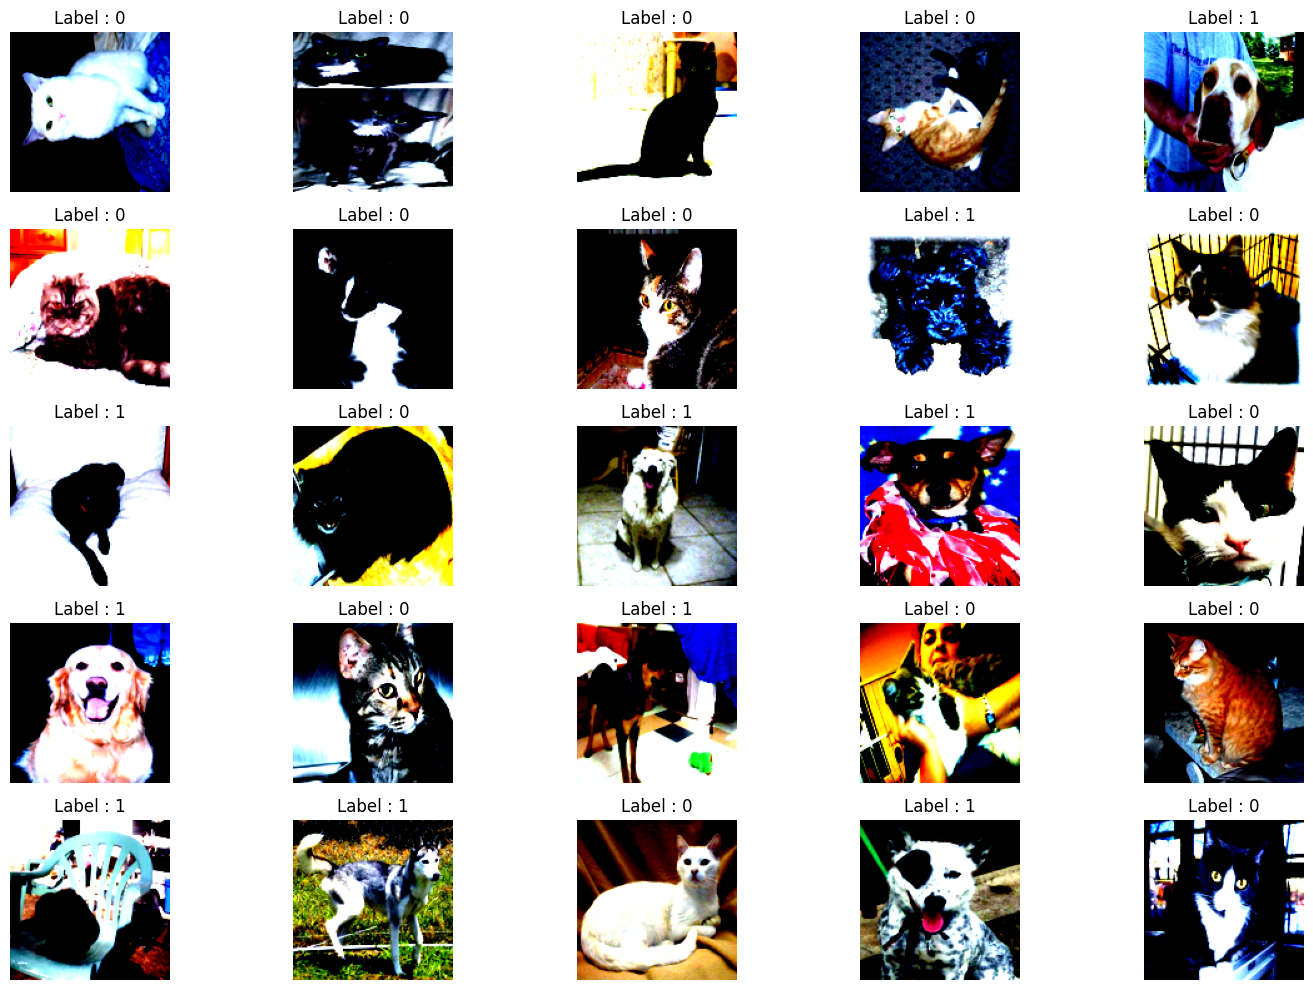

In [15]:
# Get a batch of images and labels from the train_loader
images, labels = next(iter(train_loader))

# Set up the 5x5 grid for plotting
fig, axes = plt.subplots(5, 5, figsize=(15, 10))

# Loop through the 5x5 grid and plot images
for i in range(5):
    for j in range(5):
        ax = axes[i, j]
        img = images[i * 5 + j]


        label=labels[i*5+j].item()
       

        # Denormalize the image (if you used normalization)
        img = img.permute(1, 2, 0)  # Change from CxHxW to HxWxC
        ax.imshow(img)
        ax.set_title(f"Label : {label}")
        ax.axis('off')  # Hide axis

# Show the plot
plt.tight_layout()
plt.show()

# Build Model

In [16]:

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Correcting the input size for fc1
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 256),  # 12544 is the correct feature size
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(128, 2),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)


model = CNN().to(device)

summary(model, input_size=(3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             448
              ReLU-2         [-1, 16, 126, 126]               0
         MaxPool2d-3           [-1, 16, 63, 63]               0
            Conv2d-4           [-1, 32, 61, 61]           4,640
              ReLU-5           [-1, 32, 61, 61]               0
         MaxPool2d-6           [-1, 32, 30, 30]               0
            Conv2d-7           [-1, 64, 28, 28]          18,496
              ReLU-8           [-1, 64, 28, 28]               0
         MaxPool2d-9           [-1, 64, 14, 14]               0
          Flatten-10                [-1, 12544]               0
           Linear-11                  [-1, 256]       3,211,520
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
             ReLU-14                  [

### **Defining a Loss Function and Optimizer**

We need to define what type of loss we'll be using and what method will be using to update the gradients.
1. We use Cross Entropy Loss 
2. We use the Adam Optimization Descent Algorithm - we also specify a learn rate (LR) of 0.0005.
3. Set our epochs to 50

In [17]:
criterion = nn.CrossEntropyLoss().to(device)
optimiser = optim.Adam(model.parameters(),lr=0.0005)
epochs = 10

# Train & Valid Loop

In [18]:
import torch
from tqdm import tqdm
from tabulate import tabulate

# Initialize history dictionary
history = {"Epoch": [], "Train Loss": [], "Train Accuracy": [], "Val Loss": [], "Val Accuracy": []}

for epoch in range(epochs):
    model.train()
    total = 0
    correct = 0
    train_running_loss = 0
    
    with tqdm(train_loader, unit="batch") as tepoch:  # Use DataLoader instead of dataset
        tepoch.set_description(f'Epoch {epoch+1}/{epochs}')
        
        for data, label in tepoch:
            data, label = data.to(device), label.to(device)
            optimiser.zero_grad()
            output = model(data)
            loss = criterion(output, label)
            loss.backward()
            optimiser.step()

            train_running_loss += loss.item() * data.size(0)
            _, pred = torch.max(output.data, 1)
            total += label.size(0)
            correct += (pred == label).sum().item()
        
    train_accuracy = correct / total
    train_loss = train_running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1} Training Accuracy = {train_accuracy:.4f}')
    print(f'Epoch {epoch+1} Training Loss = {train_loss:.4f}')

    # Validation Step
    model.eval()
    total = 0
    correct = 0
    val_running_loss = 0
    
    with torch.no_grad():
        with tqdm(val_loader, unit="batch") as vepoch:
            vepoch.set_description(f'Validation {epoch+1}/{epochs}')
            
            for val_data, val_label in vepoch:
                val_data, val_label = val_data.to(device), val_label.to(device)
                val_output = model(val_data)
                loss_val = criterion(val_output, val_label)

                val_running_loss += loss_val.item() * val_data.size(0)
                _, pred = torch.max(val_output.data, 1)
                total += val_label.size(0)
                correct += (pred == val_label).sum().item()
    
    val_accuracy = correct / total
    val_loss = val_running_loss / len(val_loader.dataset)
    print(f'Epoch {epoch+1} Validation Accuracy = {val_accuracy:.4f}')
    print(f'Epoch {epoch+1} Validation Loss = {val_loss:.4f}')

    # Store results in history
    history["Epoch"].append(epoch + 1)
    history["Train Loss"].append(train_loss)
    history["Train Accuracy"].append(train_accuracy)
    history["Val Loss"].append(val_loss)
    history["Val Accuracy"].append(val_accuracy)

# Print training summary in a table
print("\nTraining Summary:")
print(tabulate(history, headers="keys", tablefmt="pretty"))


Epoch 1/10: 100%|██████████| 719/719 [01:52<00:00,  6.42batch/s]


Epoch 1 Training Accuracy = 0.6889
Epoch 1 Training Loss = 0.5960


Validation 1/10: 100%|██████████| 63/63 [00:07<00:00,  8.12batch/s]


Epoch 1 Validation Accuracy = 0.7480
Epoch 1 Validation Loss = 0.5501


Epoch 2/10: 100%|██████████| 719/719 [01:29<00:00,  8.07batch/s]


Epoch 2 Training Accuracy = 0.7788
Epoch 2 Training Loss = 0.5212


Validation 2/10: 100%|██████████| 63/63 [00:07<00:00,  8.25batch/s]


Epoch 2 Validation Accuracy = 0.7665
Epoch 2 Validation Loss = 0.5274


Epoch 3/10: 100%|██████████| 719/719 [01:28<00:00,  8.10batch/s]


Epoch 3 Training Accuracy = 0.8171
Epoch 3 Training Loss = 0.4864


Validation 3/10: 100%|██████████| 63/63 [00:07<00:00,  8.42batch/s]


Epoch 3 Validation Accuracy = 0.8050
Epoch 3 Validation Loss = 0.4963


Epoch 4/10: 100%|██████████| 719/719 [01:26<00:00,  8.34batch/s]


Epoch 4 Training Accuracy = 0.8434
Epoch 4 Training Loss = 0.4637


Validation 4/10: 100%|██████████| 63/63 [00:07<00:00,  8.74batch/s]


Epoch 4 Validation Accuracy = 0.8255
Epoch 4 Validation Loss = 0.4840


Epoch 5/10: 100%|██████████| 719/719 [01:26<00:00,  8.32batch/s]


Epoch 5 Training Accuracy = 0.8691
Epoch 5 Training Loss = 0.4408


Validation 5/10: 100%|██████████| 63/63 [00:07<00:00,  8.36batch/s]


Epoch 5 Validation Accuracy = 0.8085
Epoch 5 Validation Loss = 0.4913


Epoch 6/10: 100%|██████████| 719/719 [01:26<00:00,  8.33batch/s]


Epoch 6 Training Accuracy = 0.8870
Epoch 6 Training Loss = 0.4234


Validation 6/10: 100%|██████████| 63/63 [00:07<00:00,  8.28batch/s]


Epoch 6 Validation Accuracy = 0.8100
Epoch 6 Validation Loss = 0.4942


Epoch 7/10: 100%|██████████| 719/719 [01:27<00:00,  8.23batch/s]


Epoch 7 Training Accuracy = 0.9020
Epoch 7 Training Loss = 0.4089


Validation 7/10: 100%|██████████| 63/63 [00:07<00:00,  8.67batch/s]


Epoch 7 Validation Accuracy = 0.8180
Epoch 7 Validation Loss = 0.4853


Epoch 8/10: 100%|██████████| 719/719 [01:27<00:00,  8.25batch/s]


Epoch 8 Training Accuracy = 0.9166
Epoch 8 Training Loss = 0.3950


Validation 8/10: 100%|██████████| 63/63 [00:07<00:00,  8.32batch/s]


Epoch 8 Validation Accuracy = 0.8275
Epoch 8 Validation Loss = 0.4801


Epoch 9/10: 100%|██████████| 719/719 [01:27<00:00,  8.26batch/s]


Epoch 9 Training Accuracy = 0.9243
Epoch 9 Training Loss = 0.3871


Validation 9/10: 100%|██████████| 63/63 [00:07<00:00,  8.89batch/s]


Epoch 9 Validation Accuracy = 0.8265
Epoch 9 Validation Loss = 0.4778


Epoch 10/10: 100%|██████████| 719/719 [01:26<00:00,  8.34batch/s]


Epoch 10 Training Accuracy = 0.9331
Epoch 10 Training Loss = 0.3792


Validation 10/10: 100%|██████████| 63/63 [00:07<00:00,  8.36batch/s]

Epoch 10 Validation Accuracy = 0.8150
Epoch 10 Validation Loss = 0.4925

Training Summary:
+-------+---------------------+--------------------+---------------------+--------------+
| Epoch |     Train Loss      |   Train Accuracy   |      Val Loss       | Val Accuracy |
+-------+---------------------+--------------------+---------------------+--------------+
|   1   | 0.5959517827655958  | 0.6889130434782609 | 0.5500616579055786  |    0.748     |
|   2   |  0.521227835489356  | 0.7788260869565218 | 0.5273905110359192  |    0.7665    |
|   3   | 0.48638235062101615 | 0.8170869565217391 | 0.4962809224128723  |    0.805     |
|   4   | 0.46373457103190213 | 0.843391304347826  | 0.4840110788345337  |    0.8255    |
|   5   | 0.4408072204175203  | 0.8691304347826087 | 0.4912526841163635  |    0.8085    |
|   6   | 0.4233666970937148  | 0.8869565217391304 | 0.4941587953567505  |     0.81     |
|   7   | 0.40891995953476945 | 0.9020434782608696 | 0.48529710817337035 |    0.818     |
|   8   |

# Loss & Accuracy Graph

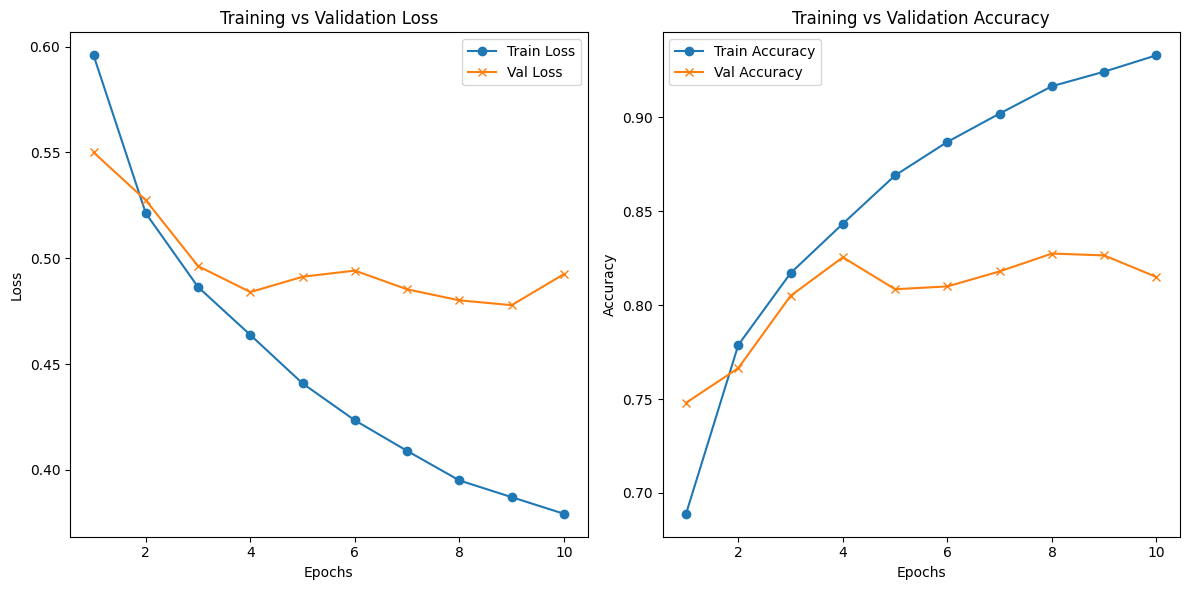

In [19]:

# Plotting the Training and Validation Loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history["Epoch"], history["Train Loss"], label='Train Loss', marker='o')
plt.plot(history["Epoch"], history["Val Loss"], label='Val Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history["Epoch"], history["Train Accuracy"], label='Train Accuracy', marker='o')
plt.plot(history["Epoch"], history["Val Accuracy"], label='Val Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Confusion Matrix

100%|██████████| 63/63 [00:06<00:00,  9.36batch/s]


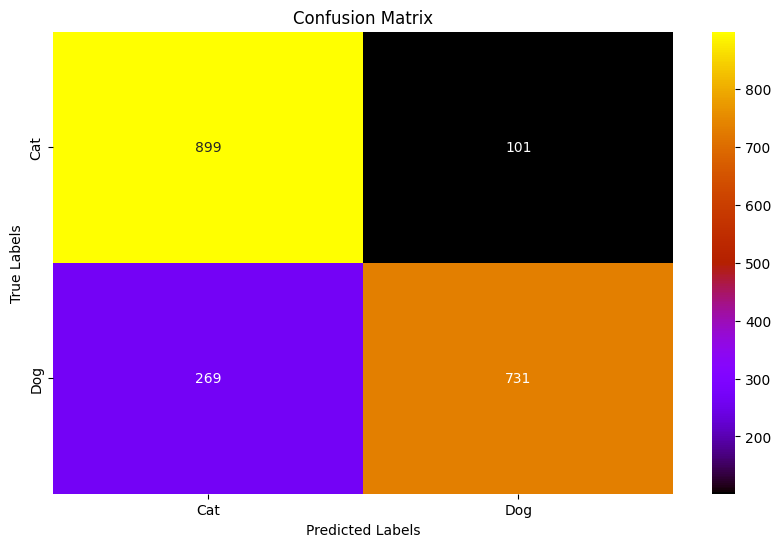

In [20]:

label_name=["Cat","Dog"]
# Initialize lists for storing predictions and true labels
all_preds = []
all_labels = []

# Get predictions for the validation set
model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for val_data, val_label in tqdm(val_loader, unit="batch"):
        val_data, val_label = val_data.to(device), val_label.to(device)
        val_output = model(val_data)
        _, preds = torch.max(val_output, 1)

        all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU and convert to numpy
        all_labels.extend(val_label.cpu().numpy())  # Move true labels to CPU and convert to numpy

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="gnuplot", xticklabels=label_name,yticklabels=label_name)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Classification Report

In [21]:
print("Classification Report:")
print(classification_report(all_labels, all_preds,target_names=label_name))

Classification Report:
              precision    recall  f1-score   support

         Cat       0.77      0.90      0.83      1000
         Dog       0.88      0.73      0.80      1000

    accuracy                           0.81      2000
   macro avg       0.82      0.81      0.81      2000
weighted avg       0.82      0.81      0.81      2000



# Roc curve

100%|██████████| 63/63 [00:06<00:00,  9.65batch/s]


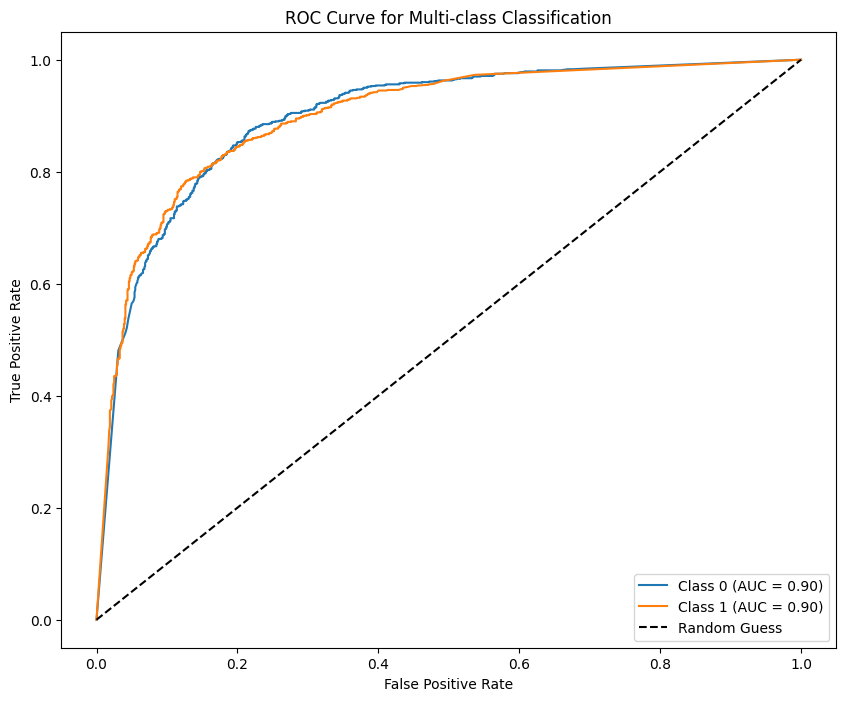

In [22]:

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Initialize lists for storing predictions and true labels
all_preds = []
all_labels = []

# Get predictions for the validation set
model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for val_data, val_label in tqdm(val_loader, unit="batch"):
        val_data, val_label = val_data.to(device), val_label.to(device)
        val_output = model(val_data)

        # Get the predicted probabilities (for ROC curve, we need these probabilities)
        val_output_probs = torch.softmax(val_output, dim=1)  # Apply softmax for multi-class probability
        
        all_preds.extend(val_output_probs.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.extend(val_label.cpu().numpy())  # Move to CPU and convert to numpy

# Binarize the true labels for multi-class ROC
n_classes = len(set(all_labels))  # Assuming labels are integer encoded
all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2, 3])  # Adjust based on your class labels

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], [output[i] for output in all_preds])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line (chance line)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Formatting the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()


# Precision recall curve

100%|██████████| 63/63 [00:06<00:00,  9.69batch/s]


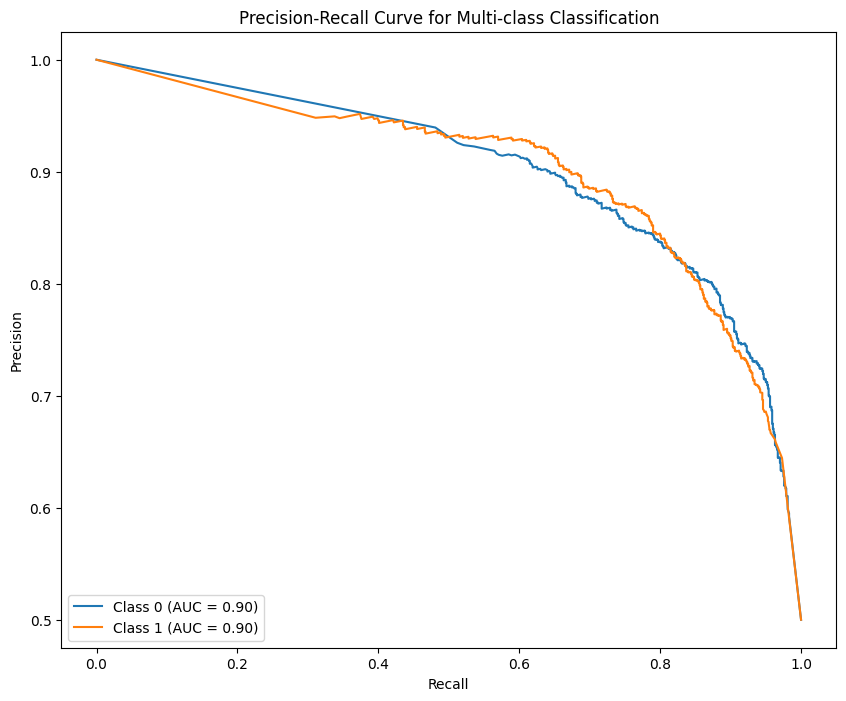

In [23]:

from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

# Initialize lists for storing predictions and true labels
all_preds = []
all_labels = []

# Get predictions for the validation set
model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for val_data, val_label in tqdm(val_loader, unit="batch"):
        val_data, val_label = val_data.to(device), val_label.to(device)
        val_output = model(val_data)

        # Get the predicted probabilities (for Precision-Recall curve, we need these probabilities)
        val_output_probs = torch.softmax(val_output, dim=1)  # Apply softmax for multi-class probability
        
        all_preds.extend(val_output_probs.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.extend(val_label.cpu().numpy())  # Move to CPU and convert to numpy

# Binarize the true labels for multi-class PR
n_classes = len(set(all_labels))  # Assuming labels are integer encoded
all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2, 3])  # Adjust based on your class labels

# Compute Precision-Recall curve and AUC for each class
precision = {}
recall = {}
pr_auc = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(all_labels_bin[:, i], [output[i] for output in all_preds])
    pr_auc[i] = auc(recall[i], precision[i])  # Calculate AUC for Precision-Recall curve

# Plot all Precision-Recall curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AUC = {pr_auc[i]:.2f})')

# Formatting the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-class Classification')
plt.legend(loc="lower left")
plt.show()


# Model Prediction

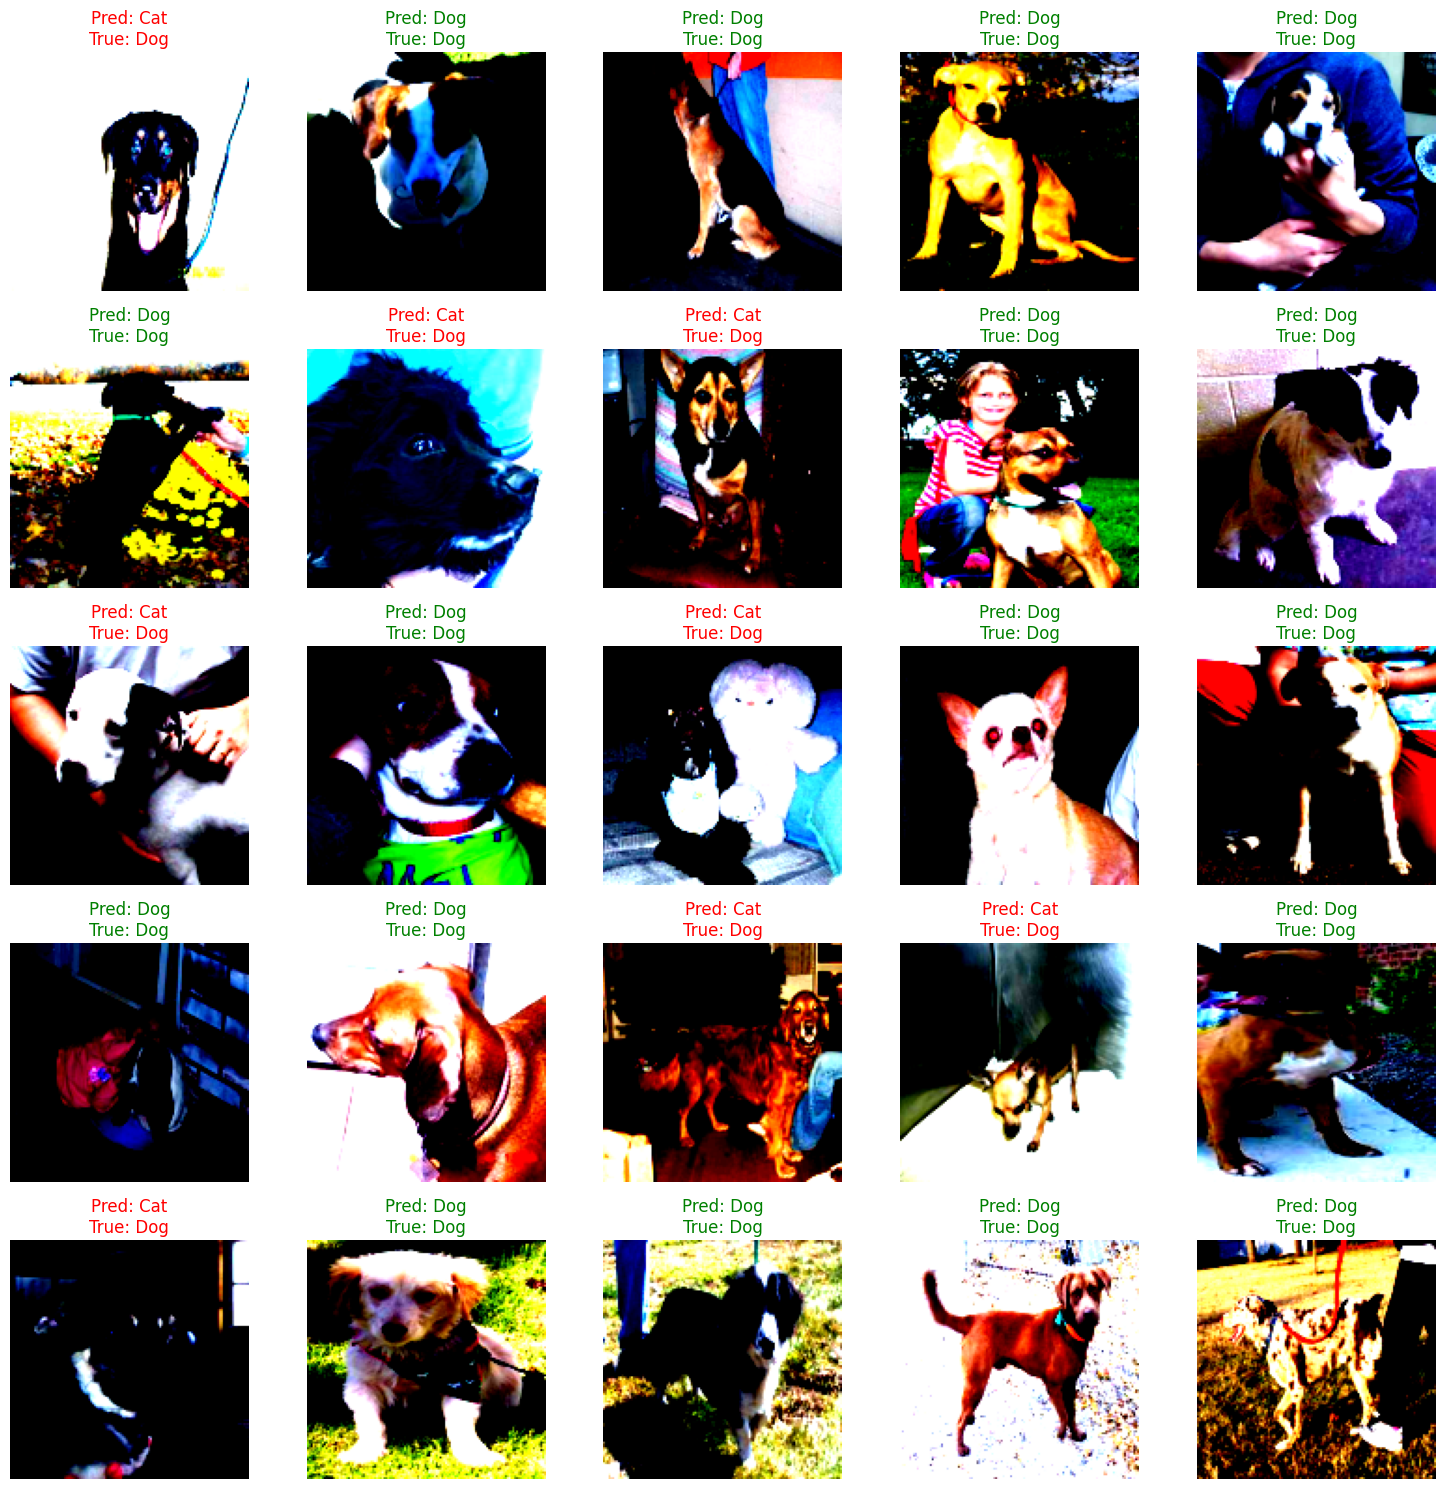

In [24]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'val_loader' is your validation DataLoader and you have the labels
label_name = ["Cat", "Dog"]  # Class names (adjust as per your dataset)

# Get the images and labels from the validation set
model.eval()
correct = 0
total = 0
fig, axes = plt.subplots(5, 5, figsize=(15, 15))  # Create a 5x5 grid

# Loop through the validation set and plot images
for idx, (data, label) in enumerate(val_loader):
    if idx >= 25:  # Limit to 25 images for the grid
        break

    data, label = data.to(device), label.to(device)

    # Get model predictions
    output = model(data)
    _, preds = torch.max(output, 1)

    # Loop through each image in the batch
    for i in range(data.size(0)):
        img = data.cpu().numpy()[i].transpose((1, 2, 0))  # Convert to HWC format
        img = np.clip(img, 0, 1)  # Ensure pixel values are within [0, 1]

        # Get the predicted and true label for the current image
        true_label = label_name[label[i].item()]
        predicted_label = label_name[preds[i].item()]

        # Check if prediction is correct or not
        is_correct = (preds[i] == label[i]).item()
        color = 'green' if is_correct else 'red'

        # Plot the image with the appropriate color
        ax = axes[idx // 5, idx % 5]
        ax.imshow(img)
        ax.axis('off')  # Turn off axis
        ax.set_title(f'Pred: {predicted_label}\nTrue: {true_label}', color=color, fontsize=12)

        # Move to the next subplot in the grid
        idx += 1
        if idx >= 25:
            break

# Adjust the layout for the subplots
plt.tight_layout()
plt.show()
